1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [193]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Latex
%matplotlib inline

,$x_1$,$x_2$,$x_3$
0,0.471435,-4.275189,-3.332319
1,-1.190976,-6.051546,-8.433498
2,1.432707,1.572393,4.437807
3,-0.312652,-5.352138,-5.977442
4,-0.720589,3.467088,2.025911
...,...,...,...
995,0.272164,2.169901,2.714229
996,0.931546,6.971691,8.834783
997,0.327532,2.671921,3.326986
998,0.740814,7.182269,8.663897


Variabilities:

Eigenvalue 1 : 0.9329306175406451
Eigenvalue 2 : 3.322093938323239e-17
Eigenvalue 3 : 0.06706938245935495
The sum of the previous variabilities has to be unitary:
 0.9329306175406451 + 3.322093938323239e-17 + 0.06706938245935495 =  1.0


,$x_1'$,$x_2'$,$x_3'$
0,5.115286,-6.995801e-16,1.854099
1,10.448121,6.354887e-16,-0.017255
2,-4.653500,-8.422504e-16,1.601291
3,7.962171,-1.291905e-16,1.037681
4,-3.564545,7.067605e-16,-1.984510
...,...,...,...
995,-3.479050,-4.265600e-17,-0.213995
996,-11.276434,-4.073901e-16,-0.606361
997,-4.270835,9.468691e-18,-0.274306
998,-11.239268,-3.977654e-16,-0.935819


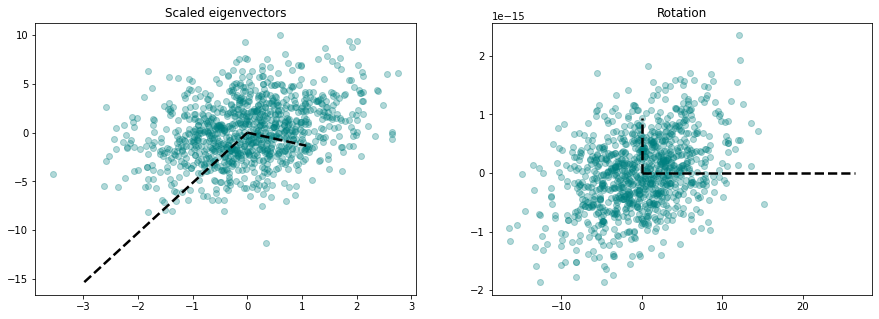

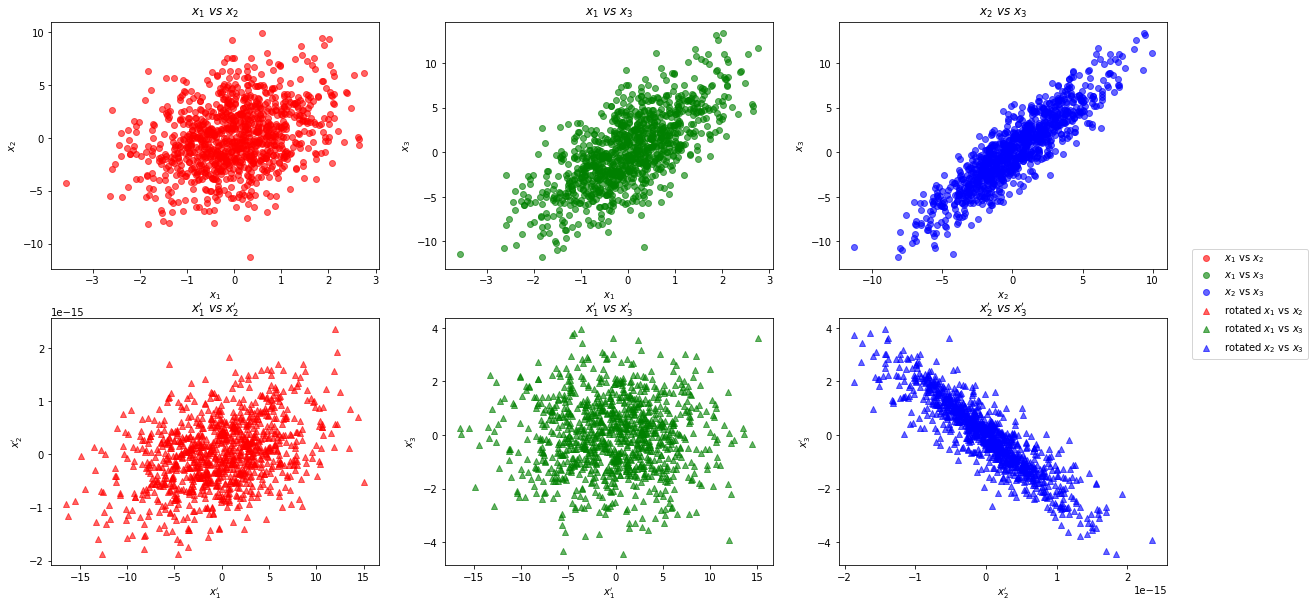

In [204]:
np.random.seed(1234)
N = 1000

x_1 = np.random.normal(0, 1, N)
x_2 = x_1+np.random.normal(0, 3, N)
x_3 = 2*x_1+x_2

# Collecting data into a dataframe and displaying it

data_set = [x_1, x_2, x_3]
df = pd.DataFrame(np.array(data_set).T, columns = ["$x_1$", "$x_2$", "$x_3$"])
display(df)

# Covariance matrix
cov_matrix = df.cov()
eigenval, eigenvec = np.linalg.eig(cov_matrix)

# SVD
U, spectrum, Vt = np.linalg.svd(cov_matrix)
D = np.diag(spectrum)
svd_matrix = np.dot(U, np.dot(D, Vt))
svd_eigenval, svd_eigenvec = np.linalg.eig(svd_matrix)

# Comparison between Covariance and SVD analysis
LAMBDA = np.diag(eigenval)
variabilities = [LAMBDA[i][i]/LAMBDA.trace() for i in range(len(LAMBDA))]
print("Variabilities:\n")
for i,j in zip(range(3), range(3)):
    print("Eigenvalue", i+1, ":", variabilities[j])
print(f"The sum of the previous variabilities has to be unitary:\n {variabilities[0]} + {variabilities[1]} + {variabilities[2]} = ", sum(variabilities))

# Plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.scatter(df["$x_1$"], df["$x_2$"], alpha = 0.3, c = 'teal', marker='o')
for val, vec in zip(eigenval, eigenvec.T):
    ax1.plot([0, val*vec[0]], [0, val*vec[1]], 'k--', linewidth = 2.5)
ax1.set_title('Scaled eigenvectors')

# Plotting in the new basis

new_data_set = np.dot(eigenvec.T, df.T)
rotated_df = pd.DataFrame(new_data_set.T, columns = ["$x_1'$", "$x_2'$", "$x_3'$"])
display(rotated_df)

ax2.scatter(rotated_df["$x_1'$"], rotated_df["$x_2'$"], alpha = 0.3, color = 'teal', marker='o')
for val, vec in zip(eigenval, np.diag([1]*3)):
    ax2.plot([0, val*vec[0]], [0, val*vec[1]], 'k--', linewidth = 2.5)
ax2.set_title('Rotation')

# Plotting all the projections in a 2x3 array 

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0][0].scatter(df["$x_1$"], df["$x_2$"], alpha=0.6, c = 'r', marker = 'o', label = '$x_1$ vs $x_2$')
ax[0][0].set(title = "$x_1 \ vs \ x_2$", xlabel = "$x_1$", ylabel = "$x_2$")
ax[0][1].scatter(df["$x_1$"], df["$x_3$"], alpha=0.6, c = 'g', marker = 'o', label ='$x_1$ vs $x_3$')
ax[0][1].set(title = "$x_1 \ vs \ x_3$", xlabel = "$x_1$", ylabel = "$x_3$")
ax[0][2].scatter(df["$x_2$"], df["$x_3$"], alpha=0.6, c = 'b', marker = 'o', label = '$x_2$ vs $x_3$')
ax[0][2].set(title = "$x_2 \ vs \ x_3$", xlabel = "$x_2$", ylabel = "$x_3$")
ax[1][0].scatter(rotated_df["$x_1'$"], rotated_df["$x_2'$"], alpha = 0.6, c = 'r', marker ='^', label = 'rotated $x_1$ vs $x_2$')
ax[1][0].set(title = "$x_1' \ vs \ x_2'$", xlabel = "$x_1'$", ylabel = "$x_2'$")
ax[1][1].scatter(rotated_df["$x_1'$"], rotated_df["$x_3'$"], alpha = 0.6, c = 'g', marker = '^', label = 'rotated $x_1$ vs $x_3$')
ax[1][1].set(title = "$x_1' \ vs \ x_3'$", xlabel = "$x_1'$", ylabel = "$x_3'$")
ax[1][2].scatter(rotated_df["$x_2'$"], rotated_df["$x_3'$"], alpha = 0.6, c = 'b', marker = '^', label = 'rotated $x_2$ vs $x_3$')
ax[1][2].set(title = "$x_2' \ vs \ x_3'$", xlabel = "$x_2'$", ylabel = "$x_3'$")
fig.legend(loc = "right")

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.471435,-4.275189,-3.332319,0.008921,0.027245,0.021654,0.017135,0.044277,0.003169,0.009915,0.030902,-0.012704,-0.005802
1,-1.190976,-6.051546,-8.433498,-0.027955,-0.007328,0.019224,-0.017429,-0.009366,-0.014931,0.013928,-0.011557,0.023779,0.005929
2,1.432707,1.572393,4.437807,0.013136,-0.024705,0.000870,-0.013417,-0.011366,0.009576,-0.006952,0.006494,-0.004868,-0.036544
3,-0.312652,-5.352138,-5.977442,0.021626,-0.029733,-0.045808,-0.021116,0.000246,0.021724,-0.026400,-0.016773,0.043814,-0.002128
4,-0.720589,3.467088,2.025911,0.010262,-0.010662,-0.009991,0.007402,0.024971,-0.000229,-0.041061,-0.013770,0.014845,0.016486
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.272164,2.169901,2.714229,-0.001861,0.028382,0.030060,-0.068378,-0.003672,0.026514,0.022647,-0.001435,-0.005557,-0.037831
996,0.931546,6.971691,8.834783,-0.006204,-0.012995,0.010037,0.014733,0.034775,0.017109,-0.006456,0.003899,0.011072,-0.007796
997,0.327532,2.671921,3.326986,-0.009588,0.024479,0.013460,-0.000584,-0.032122,0.017641,-0.011173,-0.000624,0.026721,-0.005251
998,0.740814,7.182269,8.663897,-0.024355,-0.017971,-0.013001,0.049047,-0.015304,0.020306,-0.047425,0.010186,0.023995,-0.008833


Variabilities:

Eigenvalue 1 : 0.9327991709794956
Eigenvalue 2 : 0.06706005709612128
Eigenvalue 3 : -2.1009672987018547e-17
Eigenvalue 4 : 1.647690481023043e-05
Eigenvalue 5 : 1.1855908737515891e-05
Eigenvalue 6 : 1.5517999441013752e-05
Eigenvalue 7 : 1.536840590045418e-05
Eigenvalue 8 : 1.246869868397547e-05
Eigenvalue 9 : 1.4514128374556144e-05
Eigenvalue 10 : 1.4257055447987445e-05
Eigenvalue 11 : 1.3776712147712845e-05
Eigenvalue 12 : 1.3345463822993414e-05
Eigenvalue 13 : 1.3190647016661483e-05
The sum of the previous variabilities has to be unitary:
 0.9329306175406451 + 3.322093938323239e-17 + 0.06706938245935495 + ... =  1.0000000000000002


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-5.115288,-1.854077,-9.290489e-16,-0.040297,0.011054,-0.025155,0.025074,-0.008009,-0.001192,-0.011107,-0.008699,-0.012078,-0.001290
1,-10.448119,0.017228,-4.207155e-16,0.028398,-0.000017,0.006914,-0.006187,-0.001742,-0.034636,0.003585,-0.021047,-0.014280,-0.019283
2,4.653495,-1.601310,-7.912294e-16,0.029148,0.023982,0.027923,-0.029355,-0.011639,0.016600,-0.009281,0.011726,-0.014860,-0.029264
3,-7.962171,-1.037670,-5.915846e-16,0.010367,0.019128,-0.018375,0.001704,0.003026,0.025557,-0.024766,-0.012401,-0.021132,-0.005225
4,3.564548,1.984493,1.128118e-15,0.040496,0.009853,0.030229,-0.009840,0.002243,-0.002260,0.022519,-0.017414,0.019459,-0.018660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.479049,0.213978,1.479579e-16,0.005165,0.017985,0.021857,0.011176,-0.016112,0.024631,0.008304,0.010075,0.002841,-0.007968
996,11.276433,0.606370,4.312602e-16,-0.008187,-0.006855,0.030257,-0.027398,-0.017754,0.010362,-0.015329,0.005078,0.002009,-0.003198
997,4.270832,0.274311,3.306452e-16,-0.009608,0.017837,-0.014071,0.020577,0.014470,0.000399,0.019789,0.011168,0.012723,-0.004145
998,11.239276,0.935821,9.454285e-16,0.001998,-0.015563,0.006155,0.014140,-0.008879,-0.000800,-0.020254,-0.023710,0.006072,0.006368


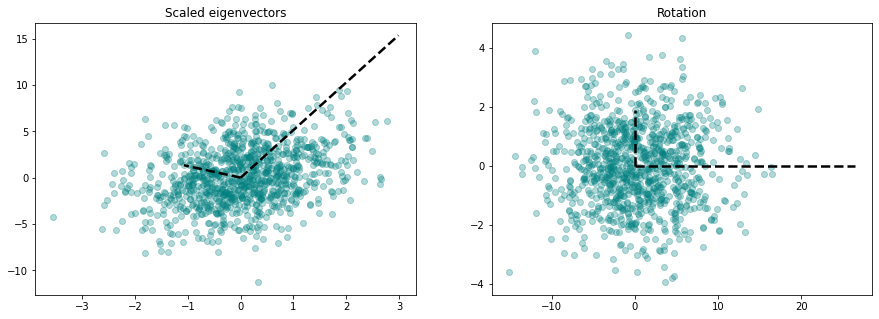

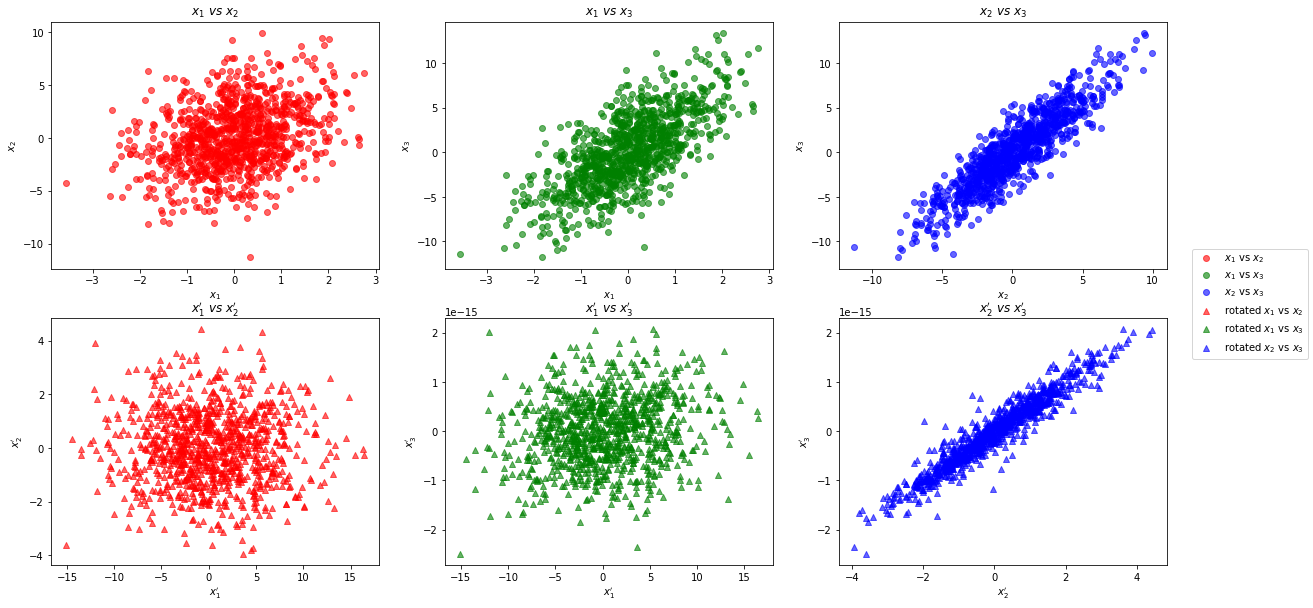

In [215]:
M = 10
new_10 = [np.random.normal(0, 1/50, N) for i in range(M)]
tot_data_set = data_set + new_10
df_new = pd.DataFrame(np.array(tot_data_set).T)
display(new_df)

# Covariance matrix
cov_matrix_new = df_new.cov()
eigenval_new, eigenvec_new = np.linalg.eig(cov_matrix_new)

# SVD
U_new, spectrum_new, Vt_new = np.linalg.svd(cov_matrix_new)
D_new = np.diag(spectrum_new)
svd_matrix_new = np.dot(U_new, np.dot(D_new, Vt_new))
svd_eigenval_new, svd_eigenvec_new = np.linalg.eig(svd_matrix_new)

# Comparison between Covariance and SVD analysis
LAMBDA_new = np.diag(eigenval_new)
variabilities_new = [LAMBDA_new[i][i]/LAMBDA_new.trace() for i in range(len(LAMBDA_new))]
print("Variabilities:\n")
for i,j in zip(range(3+M), range(3+M)):
    print("Eigenvalue", i+1, ":", variabilities_new[j])
print(f"The sum of the previous variabilities has to be unitary:\n {variabilities[0]} + {variabilities[1]} + {variabilities[2]} + ... = ", sum(variabilities_new))

# Plotting (we can notice some variations introduced by the noise...)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.scatter(df_new[0], df_new[1], alpha = 0.3, c = 'teal', marker='o')
for val, vec in zip(eigenval_new, eigenvec_new.T):
    ax1.plot([0, val*vec[0]], [0, val*vec[1]], 'k--', linewidth = 2.5)
ax1.set_title('Scaled eigenvectors')

# Plotting in the new basis

newest_data_set = np.dot(eigenvec_new.T, df_new.T)
rotated_df_new = pd.DataFrame(newest_data_set.T)
display(rotated_df_new)

ax2.scatter(rotated_df_new[0], rotated_df_new[1], alpha = 0.3, color = 'teal', marker='o')
for val, vec in zip(eigenval_new, np.diag([1]*3)):
    ax2.plot([0, val*vec[0]], [0, val*vec[1]], 'k--', linewidth = 2.5)
ax2.set_title('Rotation')

# Plotting all the projections in a 2x3 array 

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0][0].scatter(df_new[0], df_new[1], alpha = 0.6, c = 'r', marker = 'o', label = '$x_1$ vs $x_2$')
ax[0][0].set(title = "$x_1 \ vs \ x_2$", xlabel = "$x_1$", ylabel = "$x_2$")
ax[0][1].scatter(df_new[0], df_new[2], alpha = 0.6, c = 'g', marker = 'o', label ='$x_1$ vs $x_3$')
ax[0][1].set(title = "$x_1 \ vs \ x_3$", xlabel = "$x_1$", ylabel = "$x_3$")
ax[0][2].scatter(df_new[1], df_new[2], alpha = 0.6, c = 'b', marker = 'o', label = '$x_2$ vs $x_3$')
ax[0][2].set(title = "$x_2 \ vs \ x_3$", xlabel = "$x_2$", ylabel = "$x_3$")
ax[1][0].scatter(rotated_df_new[0], rotated_df_new[1], alpha = 0.6, c = 'r', marker ='^', label = 'rotated $x_1$ vs $x_2$')
ax[1][0].set(title = "$x_1' \ vs \ x_2'$", xlabel = "$x_1'$", ylabel = "$x_2'$")
ax[1][1].scatter(rotated_df_new[0], rotated_df_new[2], alpha = 0.6, c = 'g', marker = '^', label = 'rotated $x_1$ vs $x_3$')
ax[1][1].set(title = "$x_1' \ vs \ x_3'$", xlabel = "$x_1'$", ylabel = "$x_3'$")
ax[1][2].scatter(rotated_df_new[1], rotated_df_new[2], alpha = 0.6, c = 'b', marker = '^', label = 'rotated $x_2$ vs $x_3$')
ax[1][2].set(title = "$x_2' \ vs \ x_3'$", xlabel = "$x_2'$", ylabel = "$x_3'$")
fig.legend(loc = "right")

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 